# ABIDAR Bouchra, BOUSSEBAINE Mustapha et LARBI Abderahmane
# TP : Données manquantes : Imputation et Co-clustering

### MLDS 2019/2020
### Encadré : M. NADIF

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import random
import scipy
import scipy.io
from itertools import groupby
import io
import random
%matplotlib inline
import scipy.io as sio
import scipy.io as io
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)
from scipy import sparse 
from sklearn.metrics import confusion_matrix
from coclust.coclustering import CoclustInfo
from coclust.evaluation.external import accuracy as ACCURACY
from coclust.visualization import plot_delta_kl, plot_convergence
from coclust.coclustering import CoclustInfo 
from coclust.coclustering import CoclustSpecMod
from coclust.coclustering import CoclustMod
from coclust.clustering import SphericalKmeans
from coclust.coclust import *
from random import randrange
from sklearn.utils import check_random_state, check_array
from scipy.sparse.sputils import isdense
from sklearn.metrics import (adjusted_rand_score as ari,normalized_mutual_info_score as nmi)
from coclust.evaluation.external import accuracy as ACCURACY

In [4]:
def random_init(n_clusters, n_cols, random_state=None):
    random_state = check_random_state(random_state)
    W_a = random_state.randint(n_clusters, size=n_cols)
    W = np.zeros((n_cols, n_clusters))
    W[np.arange(n_cols), W_a] = 1
    return W

###  <font color='PURPLE'>Select_block</font> : permet de selectionner un bloque de données à partir d'une matrice sachant le cluster des lignes e le cluster des colonnes.

input : - X = matrice (numpy array)
        -     Z = numpy array des clusters des lignes
        -     W = numpy array des clusters des colonnes
        -     z = le cluster des lignes à séléctionner 
        -     w = le cluster des colonnes à séléctionner
output:
        -    Block = matrice(numpy array) du bloque.

In [5]:
def select_block(X,Z, W, z, w):
    block = X[np.equal(Z,z)==True]
    col_remov =[]
    for loc, i in enumerate(W):
        if i != w :
            col_remov.append(loc)
    block = np.delete(block, col_remov, axis=1)
    return block

### <font color='PURPLE'>Imput_block</font> : permet de detecter les valeurs manquante puis imputer la valeur par la valeur représentatif du cluster (bloque) aux quelle elle appartient. Dans ce cas, vu que les données ont été normalisé nous avons choisis que la moyenne du block est la valeur représentative de ce dernier.
input : - X = matrice (numpy array)

    -     Z = numpy array des clusters des lignes
    -     W = numpy array des clusters des colonnes
    -     X_trace = matrice (numpy array) équivalente à X avant l'imputation (contenant des valeur NAN)
output:

    -    X_res = matrice(numpy array) sans valeur NAN.

In [6]:
def imput_block(X, Z, W, X_trace):
    X_res = X_trace
    na_values_cord = np.argwhere(np.isnan(X_res))
    na_values_block = [(Z[i],W[j]) for i,j in na_values_cord]
    for loc,cord in enumerate(na_values_cord):
        z_ = na_values_block[loc][0]
        w_ = na_values_block[loc][1]
        block = select_block(X,Z, W, z_, w_)
        mean_bloc = np.mean(block)
        X_res[cord[0]][cord[1]] = mean_bloc
    return X_res

### La même fonction que imput_block mais adapaté à CoclustMod : <font color='PURPLE'> imput_block_mod</font>  

In [7]:
def imput_block_mod(B, Z, W, X_trace):
    B_res = B
    na_values_cord = np.argwhere(np.isnan(X_trace))
    na_values_block = [(Z[i],W[j]) for i,j in na_values_cord]
    for loc,cord in enumerate(na_values_cord):
        z_ = na_values_block[loc][0]
        w_ = na_values_block[loc][1]
        block = select_block(B,Z, W, z_, w_)
        mean_bloc = np.mean(block)
        B_res[cord[0]][cord[1]] = mean_bloc
    return B_res


### 1-  <font color='PURPLE'>data_AFC_for_initialisation</font> : Récuperer les données qui ont subit une imputation des valeurs manquantes grace à AFC(missMDA) dans R .

### 2- <font color='PURPLE'>Visualisation_Matrix</font> : Plot les matrices de coclustering 
### 3- <font color='PURPLE'>metriques</font>  : Clacule le performance des Coclustering en utilisant les métriques nmi, ari et accuracy 


In [8]:
def data_AFC_for_initialisation(data):
    dataExp= pd.read_csv(data)
    return dataExp.to_numpy()


def Visualisation_Matrix(Model, Matrix_Docs_Terms, percentage): 

    reorganisation_indice_rows=np.argsort(Model.row_labels_)
    reorganisation_indice_cols=np.argsort(Model.column_labels_)
    
    Matrix=Matrix_Docs_Terms[reorganisation_indice_rows,:]
    Matrix=Matrix[:,reorganisation_indice_cols]
    
    plt.spy(Matrix,markersize=0.5,color="red",aspect='auto')
    fig =plt.gcf()
    fig.set_size_inches(6, 6)
    plt.title("Percentage des valeurs manquantes est {}".format(percentage))
    plt.show()
    

def metriques(model,y_true,y_pred):
    pred1 = model.row_labels_
    nmi_ = nmi(y_true, pred1)
    ari_ = ari(y_true, pred1)
    accuracy = ACCURACY(y_true, pred1)
    print("NMI: {}\nARI: {} ".format(nmi_, ari_))
    print("ACCURACY: %s" % accuracy)
    return nmi_, ari_, accuracy
    

### 1- <font color='PURPLE'>random_imput</font>  : permet d'imputer les valeurs manquantes sur une matrice X avec un valeur random entre 0 et 1 vu que les données sont normalisé. (cette fonction est utulisé pour initialisé les algorithmes au début).

### 2- <font color='PURPLE'> generer_valeur_null </font> : étant donné une matrice X et un taux la fonction générer à partir de cette matrice une matrice avec le taux spécifié de valeur NULL (NAN), l'emplacement des ces valeurs est aléatoire.

In [9]:
def random_imput(X):
    mean = X.mean()
    X_res = X
    na_values_cord = np.argwhere(np.isnan(X_res))
    for cord in na_values_cord:
        X_res[cord[0]][cord[1]] = random.random()
    return X_res
    

def genrer_valeur_null(x, taux):
    x = x.astype(float)
    N = x.shape[0] * x.shape[1]
    n_retire = int(N * taux)
    for i in range(n_retire):
        a = random.randint(0,x.shape[0]-1)
        b = random.randint(0,x.shape[1]-1)
        x[a][b] = np.nan
    return x
    

### <font color='PURPLE'>data_missing_percent </font>  : récuperer les données avec percentage différents des valeurs manquantes sous format csv 

In [10]:
def data_missing_percent(dtm, ratio, name):
    data_missing = genrer_valeur_null(dtm.toarray(), ratio)
    pd.DataFrame(data_missing).to_csv("data_imputation/DataValeurManquante_{}_{}percent.csv".format(name,int(ratio*100)),header=True, index=False)
    print(" {}% is Done ".format(int(ratio*100)))

### <font color='PURPLE'>rmes_data_original_imputer </font>  : fonction pour comparer imputation avec coclustInfo et AFC itérative 

In [11]:
from sklearn.metrics import mean_squared_error
def rmes_data_original_imputer(data_original, data_imputer, data_Nan):
    indice_Nan_Values = np.argwhere(np.isnan(data_Nan))
    list_imputer =[]
    list_original= []
    for i in range(0,indice_Nan_Values.shape[0]):  
        list_imputer.append(data_imputer[indice_Nan_Values[i][0]][indice_Nan_Values[i][1]])
        list_original.append(data_original.toarray()[indice_Nan_Values[i][0]][indice_Nan_Values[i][1]])
    
    return mean_squared_error(list_original, list_imputer)

### <font color='PURPLE'>models_comparaison </font>   : Pour comparer les coclcustering en terme de métrique et visualisation 

In [12]:
def models_comparaison(data,ratio,algo,y_true,n_row_clusters,n_col_clusters):
    model = algo(n_row_clusters = 4, n_col_clusters = 4,n_init = 1, random_state = 0)
    model.fit(data)
    metriques(model,y_true,model.row_labels_)
    Visualisation_Matrix(model,data, ratio)
    #confusion_matrix(y_true, model.row_labels_)

### Table descriptif des dataSets

In [13]:
# Matrices
mats = ['classic4.mat', 'cstr.mat','WebACE.mat','reviews.mat']
mats = [m.replace('.mat','') for m in mats]

#lecture des matrices
mts = [sio.loadmat('classic4.mat')['mat'],sparse.csr_matrix(sio.loadmat('cstr.mat')['fea']),sparse.csr_matrix(sio.loadmat('WebACE.mat')['fea']),sparse.csr_matrix(sio.loadmat('reviews.mat')['dtm'].todense())]
labels = [sio.loadmat('classic4.mat')['labels'][0],sio.loadmat('cstr.mat')['gnd'].transpose()[0],sio.loadmat('WebACE.mat')['gnd'].transpose()[0],sio.loadmat('reviews.mat')['classid'].transpose()[0] ]

#Tailles des matrices
sizes = [str(m.shape[0])+" x "+str(m.shape[1]) for m in mts]

#Sparcité
spasities = [str(round(1 - m.getnnz() / (m.shape[0] * m.shape[1]),3)*100)+' %' for m in mts]

#Nbr Docs
docs = [m.shape[0]for m in mts]

#Nbr Terms
terms = [m.shape[1]for m in mts]

#Balance des Classes
classiclabels = sio.loadmat('classic4.mat')['labels'][0]
csrlabels = [a[0] for a in sio.loadmat('cstr.mat')['gnd']]
wedACElabels = [a[0] for a in sio.loadmat('WebACE.mat')['gnd']]
reviewslabels = [a[0] for a in sio.loadmat('reviews.mat')['classid']]

dens1 = round(sorted([len(list(group)) for key, group in groupby(classiclabels)])[0]/sorted([len(list(group)) for key, group in groupby(classiclabels)])[-1],3)
dens2 = round(sorted([len(list(group)) for key, group in groupby(csrlabels)])[0]/sorted([len(list(group)) for key, group in groupby(csrlabels)])[-1],3)
dens3 = round(sorted([len(list(group)) for key, group in groupby(wedACElabels)])[0]/sorted([len(list(group)) for key, group in groupby(wedACElabels)])[-1],3)
dens4 = round(sorted([len(list(group)) for key, group in groupby(reviewslabels)])[0]/sorted([len(list(group)) for key, group in groupby(reviewslabels)])[-1],3)

balance = [dens1,dens2,dens3,dens4]

#Nbr Classes
classes = [len([len(list(group)) for key, group in groupby(classiclabels)]),len([len(list(group)) for key, group in groupby(csrlabels)]),len([len(list(group)) for key, group in groupby(wedACElabels)]),len([len(list(group)) for key, group in groupby(reviewslabels)])]
pd.DataFrame(np.array([mats,sizes,spasities,docs,terms,classes,balance]).transpose() ,columns = ['Matrice','Taille','Sparcité','Nb Docs','Nb terms','NB Classes','Balance']).set_index('Matrice')

,Taille,Sparcité,Nb Docs,Nb terms,NB Classes,Balance
Matrice,,,,,,
classic4,7094 x 5896,99.4 %,7094,5896,4,0.323
cstr,475 x 1000,96.6 %,475,1000,4,0.399
WebACE,2340 x 1000,93.89999999999999 %,2340,1000,20,0.018
reviews,4069 x 18483,99.0 %,4069,18483,5,0.099


### Les deux Class <font color='PURPLE'> CoclustInfoImput </font> et <font color='PURPLE'>CoclustModImput </font> permettent de réaliser un Coclustering sur des matrices avec des valeurs manquantes, en réalisant une imputation itérative à chaque changement de clustering en lignes ou en clonnes en remplaçant cette valeur par la valeur représentative du block auquel elle appartient. 

In [14]:
class CoclustInfoImput(CoclustInfo):
    
    def __init__(self, n_row_clusters=2, n_col_clusters=2, init=None,
                 max_iter=20, n_init=1, tol=1e-9, random_state=None):
        super().__init__(n_row_clusters, n_col_clusters, init, max_iter, n_init, tol, random_state)
        #Imputer = Imput_method
        
        
    def fit(self, X, y=None):
        """Perform co-clustering.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """
        random_state = check_random_state(self.random_state)

        check_array(X, accept_sparse=True, dtype="numeric", order=None,
                    copy=False, force_all_finite='allow-nan', ensure_2d=True,
                    allow_nd=False, ensure_min_samples=self.n_row_clusters,
                    ensure_min_features=self.n_col_clusters,
                    warn_on_dtype=False, estimator=None)

        #check_positive(X)

        X = X.astype(float)

        criterion = self.criterion
        criterions = self.criterions
        row_labels_ = self.row_labels_
        column_labels_ = self.column_labels_
        delta_kl_ = self.delta_kl_

        seeds = random_state.randint(np.iinfo(np.int32).max, size=self.n_init)
        for seed in seeds:
            self._fit_single(X, seed, y)
            if np.isnan(self.criterion):
                raise ValueError("matrix may contain negative or "
                                 "unexpected NaN values")
            # remember attributes corresponding to the best criterion
            if (self.criterion > criterion):
                criterion = self.criterion
                criterions = self.criterions
                row_labels_ = self.row_labels_
                column_labels_ = self.column_labels_
                delta_kl_ = self.delta_kl_

        # update attributes
        self.criterion = criterion
        self.criterions = criterions
        self.row_labels_ = row_labels_
        self.column_labels_ = column_labels_
        self.delta_kl_ = delta_kl_

        return self
    
    
    def random_init(self, n_clusters, n_cols, random_state=None):

        random_state = check_random_state(random_state)
        W_a = random_state.randint(n_clusters, size=n_cols)
        W = np.zeros((n_cols, n_clusters))
        W[np.arange(n_cols), W_a] = 1
        
        return W
    
    
    def _fit_single(self, X, random_state, y=None):
        """Perform one run of co-clustering.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """
        
        X_trace = X ## X_trace garde la trace des valeurs null dans X avant l'imputation.
        
        K = self.n_row_clusters
        L = self.n_col_clusters
        
        if self.init is None:
            W = self.random_init(L, X.shape[1], random_state)
        else:
            W = np.matrix(self.init, dtype=float)
        
        X = sp.csr_matrix(X)
        
        N = float(X.sum()) # Dans le cas ou la matrice contient que des 1 et des 0, N = le nombre de 1 donc le nombre de données non null.
        X = X.multiply(1. / N) # Normalisation

        Z = sp.lil_matrix(self.random_init(K, X.shape[0], self.random_state)) # K: Nombre de lignes
    
        W = sp.csr_matrix(W) 
        
        # Imputation pour l'initialisation
        # vu que c une phase d'initialisation pourquoi faire un random si on peut utiliser le KNN imputeur qui pourra accelerer la convergences.
        X = random_imput(X.toarray())
        X = sp.csr_matrix(X)

        # Initial delta
        p_il = X * W # columns
        # p_il = p_il     # matrix m,l ; column l' contains the p_il'
        p_kj = X.T * Z  # matrix j,k

        p_kd = p_kj.sum(axis=0)  # array containing the p_k.
        p_dl = p_il.sum(axis=0)  # array containing the p_.l

        # p_k. p_.l ; transpose because p_kd is "horizontal"
        p_kd_times_p_dl = p_kd.T * p_dl
        min_p_kd_times_p_dl = np.nanmin(
            p_kd_times_p_dl[
                np.nonzero(p_kd_times_p_dl)])
        p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
        p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl

        p_kl = (Z.T * X) * W
        delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)

        change = True
        news = []

        n_iters = self.max_iter
        pkl_mi_previous = float(-np.inf)

        # Loop
        while change and n_iters > 0:
            change = False
            ## X' = X
            ## Imputation(X)
            # Update Z
            p_il = X * W  # matrix m,l ; column l' contains the p_il'
            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            
            delta_kl[delta_kl == 0.] = 0.0001  # to prevent log(0)
            log_delta_kl = np.log(delta_kl.T)
            log_delta_kl = sp.lil_matrix(log_delta_kl)
            # p_il * (d_kl)T ; we examine each cluster
            Z1 = p_il * log_delta_kl
            Z1 = Z1.toarray()
            Z = np.zeros_like(Z1)
            # Z[(line index 1...), (max col index for 1...)]
            Z[np.arange(len(Z1)), Z1.argmax(1)] = 1
            Z = sp.lil_matrix(Z)
            
            # Update delta
            # matrice d, k ; column k' contains the p_jk'
            p_kj = X.T * Z
            # p_il unchanged
            p_dl = p_il.sum(axis=0)  # array l containing the  p_.l
            p_kd = p_kj.sum(axis=0)  # array k containing the p_k.

            # p_k. p_.l ; transpose because p_kd is "horizontal"
            p_kd_times_p_dl = p_kd.T * p_dl
            min_p_kd_times_p_dl = np.nanmin(
                p_kd_times_p_dl[
                    np.nonzero(p_kd_times_p_dl)])
            p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
            p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl
            p_kl = (Z.T * X) * W
            delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)
            
            #Imputation partie 2
            X = imput_block(X.toarray(), Z.toarray().argmax(axis=1)
                            , W.toarray().argmax(axis=1)
                            , X_trace)
            X = sp.csr_matrix(X)

            #Update W
            p_kj = X.T * Z  # matrice m,l ; column l' contains the p_il'
            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001  # to prevent log(0)
            log_delta_kl = np.log(delta_kl)
            log_delta_kl = sp.lil_matrix(log_delta_kl)
            W1 = p_kj * log_delta_kl  # p_kj * d_kl ; we examine each cluster
            W1 = W1.toarray()
            W = np.zeros_like(W1)
            W[np.arange(len(W1)), W1.argmax(1)] = 1
            W = sp.lil_matrix(W)

            # Update delta
            p_il = X * W     # matrix d,k ; column k' contains the p_jk'
            # p_kj unchanged
            p_dl = p_il.sum(axis=0)  # array l containing the p_.l
            p_kd = p_kj.sum(axis=0)  # array k containing the p_k.

            # p_k. p_.l ; transpose because p_kd is "horizontal"
            p_kd_times_p_dl = p_kd.T * p_dl
            min_p_kd_times_p_dl = np.nanmin(
                p_kd_times_p_dl[
                    np.nonzero(p_kd_times_p_dl)])
            p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
            p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl
            p_kl = (Z.T * X) * W

            delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)
            
            
            #Imputation partie 4
            X = imput_block(X.toarray(), Z.toarray().argmax(axis=1)
                            , W.toarray().argmax(axis=1)
                            , X_trace)
            X = sp.csr_matrix(X)
            # to prevent log(0) when computing criterion
            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001


            # Criterion
            pkl_mi = sp.lil_matrix(p_kl).multiply(
                sp.lil_matrix(np.log(delta_kl)))
            pkl_mi = pkl_mi.sum()

            if np.abs(pkl_mi - pkl_mi_previous) > self.tol:
                pkl_mi_previous = pkl_mi
                change = True
                news.append(pkl_mi)
                n_iters -= 1

        self.criterions = news
        self.criterion = pkl_mi
        self.row_labels_ = Z.toarray().argmax(axis=1).tolist()
        self.column_labels_ = W.toarray().argmax(axis=1).tolist()
        self.delta_kl_ = delta_kl
        self.X = X
        self.Z = Z
        self.W = W

In [15]:
class CoclustModImput(CoclustMod):

    def __init__(self, n_clusters=2, init=None, max_iter=20, n_init=1,
                 tol=1e-9, random_state=None):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.random_state = random_state

        self.row_labels_ = None
        self.column_labels_ = None
        self.modularity = -np.inf
        self.modularities = []
    

    def fit(self, X, y=None):
        """Perform co-clustering by direct maximization of graph modularity.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """

        random_state = check_random_state(self.random_state)
        
        check_array(X, accept_sparse=True, dtype="numeric", order=None,
                    copy=False, force_all_finite='allow-nan', ensure_2d=True,
                    allow_nd=False, ensure_min_samples=self.n_clusters,
                    ensure_min_features=self.n_clusters,
                    warn_on_dtype=False, estimator=None)
        

#         if type(X) == np.ndarray:
#             X = np.matrix(X)

        X = np.array(X)

        X = X.astype(float)

        modularity = self.modularity
        modularities = []
        row_labels_ = None
        column_labels_ = None

        seeds = random_state.randint(np.iinfo(np.int32).max, size=self.n_init)
        for seed in seeds:
            self._fit_single(X, seed, y)
            if np.isnan(self.modularity):
                raise ValueError("matrix may contain unexpected NaN values")
            # remember attributes corresponding to the best modularity
            if (self.modularity > modularity):
                modularity = self.modularity
                modularities = self.modularities
                row_labels_ = self.row_labels_
                column_labels_ = self.column_labels_

        # update attributes
        self.modularity = modularity
        self.modularities = modularities
        self.row_labels_ = row_labels_
        self.column_labels_ = column_labels_

        return self

    def _fit_single(self, X, random_state, y=None):
        """Perform one run of co-clustering by direct maximization of graph
        modularity.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """
        X_trace = X ## trace des valeurs manquantes

        if self.init is None:
            W = random_init(self.n_clusters, X.shape[1], random_state)
        else:
            W = np.matrix(self.init, dtype=float)

        Z = np.zeros((X.shape[0], self.n_clusters))
        
        X = sp.csr_matrix(X)

        ## Imputation random
        X = random_imput(X.toarray())
        X = sp.csr_matrix(X)

        # Compute the modularity matrix
        row_sums = np.matrix(X.sum(axis=1))
        col_sums = np.matrix(X.sum(axis=0))
        N = float(X.sum())
        indep = (row_sums.dot(col_sums)) / N

        # B is a numpy matrix
        B = X - indep

        self.modularities = []

        # Loop
        m_begin = float("-inf")
        change = True
        iteration = 0
        while change:
            change = False

            # Reassign rows 
            BW = B.dot(W)
            for idx, k in enumerate(np.argmax(BW, axis=1)):
                Z[idx, :] = 0
                Z[idx, k] = 1
            
            ## Imputation block
            B = imput_block_mod(np.array(B), Z.argmax(axis=1)
                            , W.argmax(axis=1)
                            , X_trace)
            B = np.matrix(B)
            

            # Reassign columns
            BtZ = (B.T).dot(Z)
            for idx, k in enumerate(np.argmax(BtZ, axis=1)):
                W[idx, :] = 0
                W[idx, k] = 1
                
            ##Imputation block
            B = imput_block_mod(np.array(B), Z.argmax(axis=1)
                            , W.argmax(axis=1)
                            , X_trace)
            B = np.matrix(B)

            k_times_k = (Z.T).dot(BW)
            m_end = np.trace(k_times_k)
            iteration += 1
            if (np.abs(m_end - m_begin) > self.tol and
                    iteration < self.max_iter):
                self.modularities.append(m_end/N)
                m_begin = m_end
                change = True

        self.row_labels_ = np.argmax(Z, axis=1).tolist()
        self.column_labels_ = np.argmax(W, axis=1).tolist()
        self.btz = BtZ
        self.bw = BW
        self.modularity = m_end / N
        self.nb_iterations = iteration
        self.X=B

    def get_assignment_matrix(self, kind, i):
        """Returns the indices of 'best' i cols of an assignment matrix
        (row or column).

        Parameters
        ----------
        kind : string
             Assignment matrix to be used: rows or cols

        Returns
        -------
        numpy array or scipy sparse matrix
            Matrix containing the i 'best' columns of a row or column
            assignment matrix
        """
        if kind == "rows":
            s_bw = np.argsort(self.bw)
            return s_bw[:, -1:-(i+1):-1]
        if kind == "cols":
            s_btz = np.argsort(self.btz)
            return s_btz[:, -1:-(i+1):-1]


In [233]:
data_missing_percent(mts[1],0.01, "cstr")
data_missing_percent(mts[1],0.02,"cstr")
data_missing_percent(mts[1],0.2)
data_missing_percent(mts[1],0.1)
data_missing_percent(mts[1],0.2)
data_missing_percent(mts[1],0.3)
data_missing_percent(mts[1],0.6)

 1% is Done 


In [25]:
data_01_NaN = genrer_valeur_null(mts[1].toarray(), 0.01)
data_02_NaN = genrer_valeur_null(mts[1].toarray(), 0.02)
data_10_NaN = genrer_valeur_null(mts[1].toarray(), 0.1)
data_20_NaN = genrer_valeur_null(mts[1].toarray(), 0.2)
data_30_NaN = genrer_valeur_null(mts[1].toarray(), 0.3)
data_60_NaN = genrer_valeur_null(mts[1].toarray(), 0.6)

In [17]:
data_01_AFC_Gen=(pd.read_csv("data_imputation/dataExpCstr01.csv")).to_numpy()
data_02_AFC_Gen=(pd.read_csv("data_imputation/dataExpCstr02.csv")).to_numpy()
data_10_AFC_Gen=(pd.read_csv("data_imputation/dataExpCstr10.csv")).to_numpy()
data_20_AFC_Gen=(pd.read_csv("data_imputation/dataExpCstr20.csv")).to_numpy()
data_30_AFC_Gen=(pd.read_csv("data_imputation/dataExpCstr30.csv")).to_numpy()
data_60_AFC_Gen=(pd.read_csv("data_imputation/dataExpCstr60.csv")).to_numpy()

## Question:    

## Comparer en termes d’imputation les deux approches l’AFC itérative et le co-clustering. Pour ce faire, générer différents taux de données manquantes. Différentes façons peuvent être imputées pour l’évaluation.

Procédures :

1- Je génére les données manquantes et je sauvgarde l'indice 
          
2- Imputation avec missMDA et CoclustInfoImput
          
3- RMSE entre les données d'origines et données imputer (CocustInfo et MissMDA)


### <font color='green'> 1- CoclustInfoImput </font> 

<font face="gras" color="black" size="4"> <b> 1- RMSE entre les données originales et données imputées par AFC itérative avec un taux des valeurs manquantes 1%

In [19]:
rmes_data_original_imputer(mts[1], data_01_AFC_Gen, data_01_NaN)

26.175486875529213

<font face="gras" color="black" size="4"> <b> 2- RMSE entre les données originales et données imputées CoclustInfoImput avec un taux des valeurs manquantes 1%

In [20]:
model = CoclustInfoImput(n_row_clusters = 4, n_col_clusters = 4,n_init = 1, random_state = 2000)
model.fit(data_01_NaN)

CoclustInfoImput(init=None, max_iter=20, n_col_clusters=4, n_init=1,
                 n_row_clusters=4, random_state=2000, tol=1e-09)

In [70]:
rmes_data_original_imputer(mts[1], model.X.toarray(), data_01_NaN)

6.9966060306516615

<font face="gras" color="black" size="4"> <b> 3- RMSE entre les données originales et données imputées par AFC itérative avec un taux des valeurs manquantes 2%

In [60]:
rmes_data_original_imputer(mts[1], data_02_AFC_Gen, data_02_NaN)

2.2421052631578946

<font face="gras" color="black" size="4"> <b> 2- RMSE entre les données originales et données imputées CoclustInfoImput avec un taux des valeurs manquantes 2%

In [61]:
model02 = CoclustInfoImput(n_row_clusters = 4, n_col_clusters = 4,n_init = 1, random_state = 2000)
model02.fit(data_02_NaN)
rmes_data_original_imputer(mts[1], model02.X.toarray(), data_02_NaN)

13.632292603568011

<font face="gras" color="red" size="4"> <b> Conclusion : <font face="gras" color="black" size="4"> <b>L'imputation avec CoclustInfo minimise plus l'erreur quadratique moyenne en comparant avec imputation de l'AFC itérative 

##  Question : 
## Réaliser un co-clustering sur le tableau complété par l’AFC itérative et comparer avec le co-clustering obtenu avec CoclustInfo et CoclustMod par une simple visualisation du premier plan factorie

In [21]:
def models_comparaison(data,ratio,algo,y_true,n_row_clusters,n_col_clusters):
    model = algo(n_row_clusters = 4, n_col_clusters = 4,n_init = 1, random_state = 0)
    model.fit(data)
    metriques(model,y_true,model.row_labels_)
    Visualisation_Matrix(model,data, ratio)
    #confusion_matrix(y_true, model.row_labels_)
    

<font face="gras" color="blue" size="5"> <b> 1- CocustInfo sur les données imputées gérer par AFC itérative avec un taux de valeurs manquantes 1% 

NMI: 0.6573585003564192
ARI: 0.5712190701786455 
ACCURACY: 0.6631578947368421


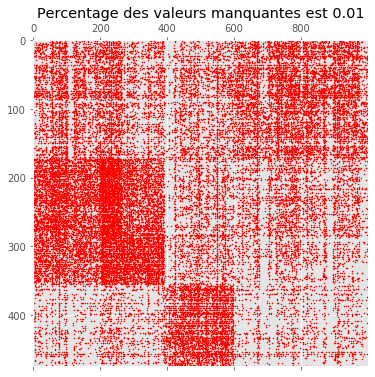

In [39]:
models_comparaison(data_01_AFC_Gen,0.01,CoclustInfo,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 2- CoclustInfoImput c'est-à-dire imputation avec coclustinfo, sur les données avec un taux des valeurs manquantes 1%

NMI: 0.6312687636859997
ARI: 0.6655710299748553 
ACCURACY: 0.7978947368421052


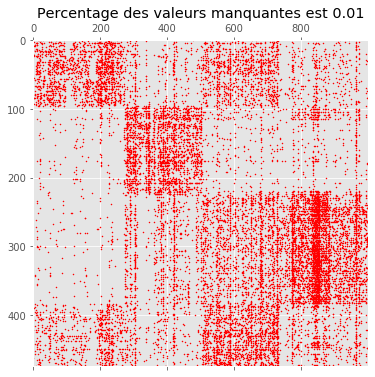

In [40]:
models_comparaison(data_01_NaN,0.01,CoclustInfoImput,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 3- CocustInfo sur les données imputées gérer par AFC itérative avec un taux de valeurs manquantes 2% 

NMI: 0.6686003264995342
ARI: 0.630593329214539 
ACCURACY: 0.7326315789473684


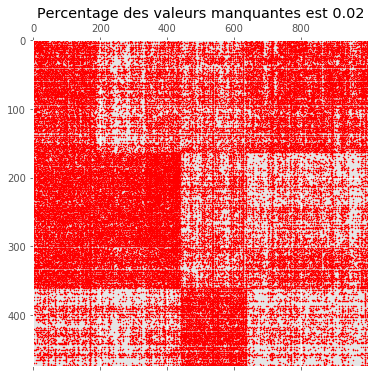

In [23]:
models_comparaison(data_02_AFC_Gen,0.02,CoclustInfo,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 4- CoclustInfoImput c'est-à-dire imputation avec coclustinfo, sur les données avec un taux des valeurs manquantes 2%

NMI: 0.627847745087089
ARI: 0.6206384275404031 
ACCURACY: 0.7705263157894737


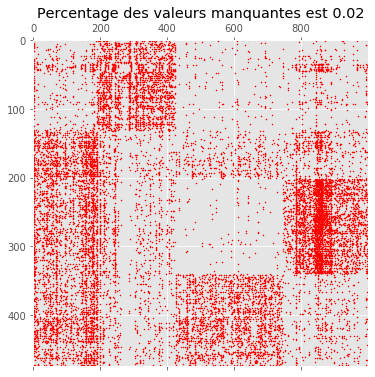

In [27]:
models_comparaison(data_02_NaN,0.02,CoclustInfoImput,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 5- CocustInfo sur les données imputées gérer par AFC itérative avec un taux de valeurs manquantes 20% 

NMI: 0.6863634544993874
ARI: 0.6013625859983075 
ACCURACY: 0.6989473684210527


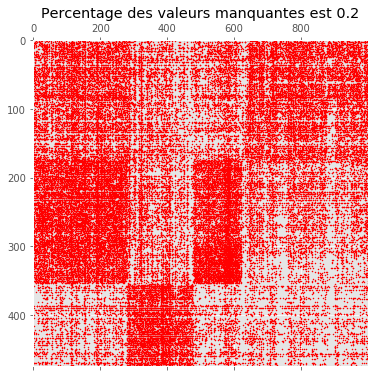

In [24]:
models_comparaison(data_20_AFC_Gen,0.2,CoclustInfo,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 6- CoclustInfoImput c'est-à-dire imputation avec coclustinfo, sur les données avec un taux des valeurs manquantes 20%

NMI: 0.5845088346386299
ARI: 0.6113645335522122 
ACCURACY: 0.7957894736842105


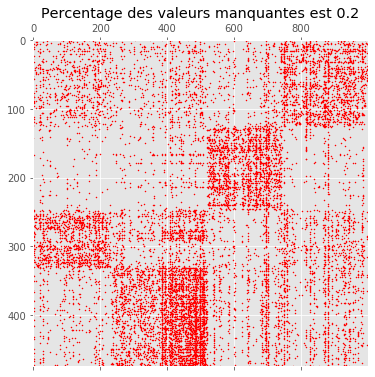

In [22]:
models_comparaison(data_20_NaN,0.2,CoclustInfoImput,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 7- CocustInfo sur les données imputées gérer par AFC itérative avec un taux de valeurs manquantes 10% 

NMI: 0.6573585003564192
ARI: 0.5712190701786455 
ACCURACY: 0.6631578947368421


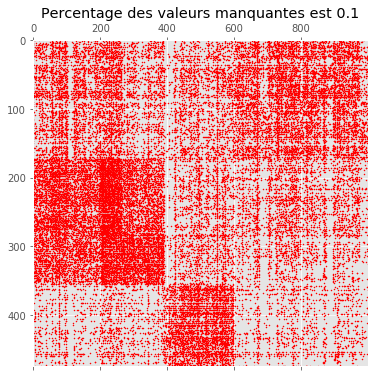

In [41]:
models_comparaison(data_10_AFC_Gen,0.1,CoclustInfo,labels[1],4,4)

<font face="gras" color="blue" size="5"> <b> 8- CoclustInfoImput c'est-à-dire imputation avec coclustinfo, sur les données avec un taux des valeurs manquantes 10%

NMI: 0.677966859015552
ARI: 0.5801612091106492 
ACCURACY: 0.6610526315789473


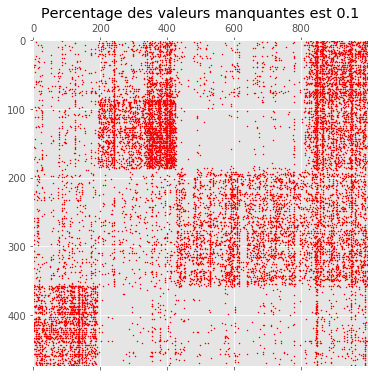

In [42]:
data_10_NaN = genrer_valeur_null(mts[1].toarray(), 0.02)
models_comparaison(data_10_NaN,0.1,CoclustInfoImput,labels[1],4,4)

### <font color='Green' size="5"> 2- CoclustModImput </font> 

### Objectif : Comparer la qualité d'imputation avec les deux méthodes 
### 1- On calcule les modeles avec plusiers percentage des valeurs manquantes 
### 2 - On récupere la matrice avec les valeurs imputées en utilisant CoCLustModImput
### 3 - Oncompare le Rmse de données originale et données imputées par AFC itérative ensuite données originales avec les données Imputées par CoclustModImput 


In [30]:
#1% valeurs manquantes 
clustMod_model01 = CoclustModImput(n_clusters=4, n_init = 1, random_state = 0)
clustMod_model01.fit(data_01_NaN)

CoclustModImput(init=None, max_iter=20, n_clusters=4, n_init=1, random_state=0,
                tol=1e-09)

In [31]:
# 2 % Valeurs manquantes 
clustMod_model02 = CoclustModImput(n_clusters=4, n_init = 1, random_state = 0)
clustMod_model02.fit(data_02_NaN)

CoclustModImput(init=None, max_iter=20, n_clusters=4, n_init=1, random_state=0,
                tol=1e-09)

In [32]:
# 10 % Valeurs manquantes 
clustMod_model10 = CoclustModImput(n_clusters=4, n_init = 1, random_state = 0)
clustMod_model10.fit(data_10_NaN)

CoclustModImput(init=None, max_iter=20, n_clusters=4, n_init=1, random_state=0,
                tol=1e-09)

In [28]:
def models_comparaison_Mod(data,ratio, algo, y_true, n_clusters):
    model = algo(n_clusters = n_clusters, n_init = 1, random_state = 0)
    model.fit(data)
    metriques(model,y_true,model.row_labels_)
    Visualisation_Matrix(model,data, ratio)
    #confusion_matrix(y_true, model.row_labels_)

In [84]:
#data_01_NaN = genrer_valeur_null(mts[1].toarray(), 0.01)
print("RMSE entres les données génèrées par AFC itérative et données originales :", rmes_data_original_imputer(mts[1], data_01_AFC_Gen, data_01_NaN))
print("RMSE entres les données génèrées par CoCLustModImput et données originales : " , rmes_data_original_imputer(mts[1], np.array(clustMod_model01.X), data_01_NaN))

RMSE entres les données génèrées par AFC itérative et données originales : 281.1585520745131
RMSE entres les données génèrées par CoCLustModImput et données originales :  86.77971975931379


In [66]:
#data_02_NaN = genrer_valeur_null(mts[1].toarray(), 0.02)
print("RMSE entres les données génèrées par AFC itérative et données originales : ", rmes_data_original_imputer(mts[1], data_02_AFC_Gen, data_02_NaN))
print("RMSE entres les données génèrées par CoCLustModImput et données originales : ", rmes_data_original_imputer(mts[1], np.array(clustMod_model02.X), data_02_NaN))

RMSE entres les données génèrées par AFC itérative et données originales :  246.81331342009815
RMSE entres les données génèrées par CoCLustModImput et données originales :  69.2689587336256


In [102]:
#data_10_NaN = genrer_valeur_null(mts[1].toarray(), 0.1)
print("RMSE entres les données génèrées par AFC itérative et données originales : ", rmes_data_original_imputer(mts[1], data_10_AFC_Gen, data_10_NaN))
print("RMSE entres les données génèrées par CoCLustModImput et données originales : ",  rmes_data_original_imputer(mts[1], np.array(clustMod_model10.X), data_10_NaN))

RMSE entres les données génèrées par AFC itérative et données originales :  133.2411492848933
RMSE entres les données génèrées par CoCLustModImput et données originales :  65.30715393133998


### Objectif : Réalisation d' un co-clustering sur le tableau complété par l’AFC itérative et comparer avec le co-clustering obtenu avec CoclustMod par une simple visualisation

<font face="gras" color="blue" size="5"> <b> 2-1- CoclustModImput c'est-à-dire imputation avec coclustMod, sur les données avec un taux des valeurs manquantes 2%

NMI: 0.34759745849918156
ARI: 0.2522096346917427 
ACCURACY: 0.5031578947368421


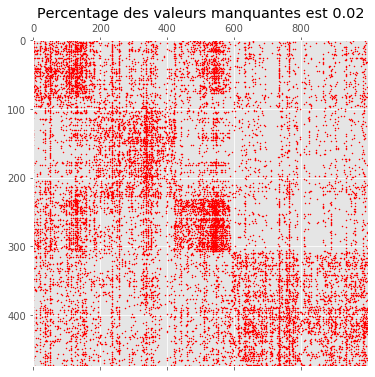

In [116]:
data_02_NaN = genrer_valeur_null(mts[1].toarray(), 0.02)
models_comparaison_Mod(data_02_NaN,0.02,CoclustModImput, labels[1],4)

<font face="gras" color="blue" size="5"> <b> 2-2- CocustMod sur les données imputées gérées par AFC itérative avec un taux de valeurs manquantes 2% 

NMI: 0.6509289484080197
ARI: 0.6783023670207993 
ACCURACY: 0.8147368421052632


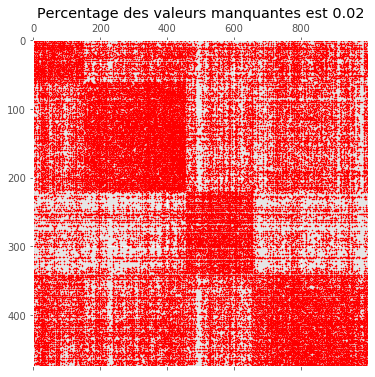

In [110]:
models_comparaison_Mod(data_02_AFC_Gen,0.02,CoclustMod, labels[1],4)

<font face="gras" color="blue" size="5"> <b> 2-3- CoclustModImput c'est-à-dire imputation avec coclustMod, sur les données avec un taux des valeurs manquantes 1%

NMI: 0.4254288589390662
ARI: 0.3876249883143732 
ACCURACY: 0.6989473684210527


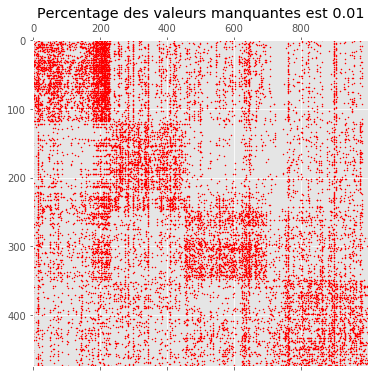

In [118]:
#data_01_NaN = genrer_valeur_null(mts[1].toarray(), 0.01)
models_comparaison_Mod(data_01_NaN,0.01,CoclustModImput, labels[1],4)

<font face="gras" color="blue" size="5"> <b> 2-4 CocustMod sur les données imputées gérées par AFC itérative avec un taux de valeurs manquantes 1% 

NMI: 0.5648779415578499
ARI: 0.47094419264438053 
ACCURACY: 0.6210526315789474


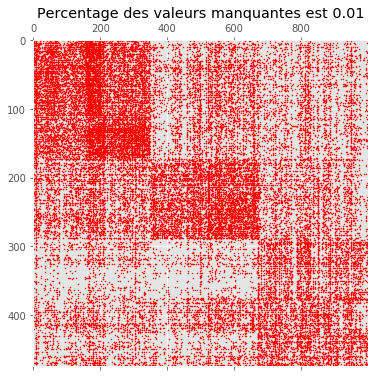

In [84]:
models_comparaison_Mod(data_01_AFC_Gen,0.01,CoclustMod, labels[1],4)

<font face="gras" color="blue" size="5"> <b> 2-5- CoclustModImput c'est-à-dire imputation avec coclustMod, sur les données avec un taux des valeurs manquantes 10%

NMI: 0.37918616872476807
ARI: 0.378433367039026 
ACCURACY: 0.6336842105263157


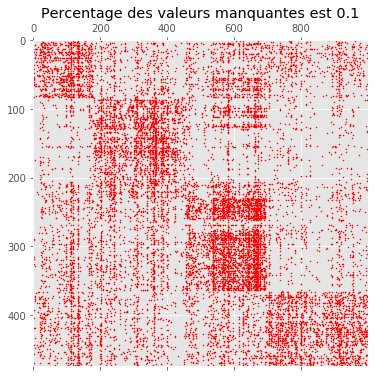

In [119]:
data_10_NaN = genrer_valeur_null(mts[1].toarray(), 0.1)
models_comparaison_Mod(data_10_NaN,0.1,CoclustModImput, labels[1],4)

<font face="gras" color="blue" size="5"> <b> 2-6 CocustMod sur les données imputées gérées par AFC itérative avec un taux de valeurs manquantes 10% 

NMI: 0.5648779415578499
ARI: 0.47094419264438053 
ACCURACY: 0.6210526315789474


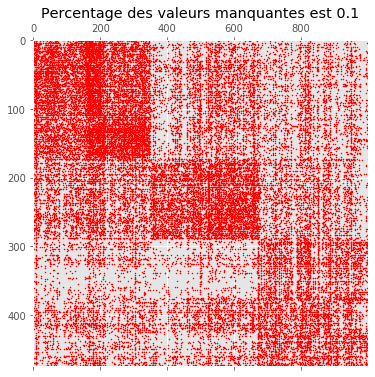

In [120]:
models_comparaison_Mod(data_10_AFC_Gen,0.1,CoclustMod, labels[1],4)

# <font color='red'>********************** Point à Rentenir</font>

## 1- Imputation avec les deux algorithmes de Coclustering : CoclustInfoImput et CoClustModmput a montré une performance remarquable au niveau de la contsruction des clustering
## 2- Les données imputées par les CoclustInfoImput et CoclustModImpt restent plus faible au niveau d'information qu'ils portent en comparant avec les données imputées par AFC itérative
## 3- Coclust avec imputation donne de meilleurs résultats par rapport à AFC itérative si le taux des valeurs manquantes est faible.
## 4- Coclust avec imputation produit des clustering plus cohéarant en comparant avec AFC itérartive 

# Question 4
1- Le coclust avec imputation a montré des résultats efficace en terme d'imputation et clustering dans les matrices sparses dont le taux de valeurs nulles reste faible(entre 1% et 10 % de valeurs manquantes).

2- Nous pouvons pensé à combiner les deux approches c'est-à dire CoCLust avec imputation et AFC itérative pour avoir des bonnes résultats lorsque nous traitons des données non sparse notamment initialiser le résultat avec un AFC itérative.

3- Il est intéréssant de faire l'imputation ainsi que le clustering simultanément plutot que séquentiellement.